# 1. Introduction

- Thematischer Fokus der Analyse: Vergleich unterschiedlicher Klassifikationsmodelle zur Identifikation europäischer Städte mit hohen Emissionswerten 



# 2. Preparation

### 2.1 Import packages

In [18]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import graphviz
np.bool = np.bool_
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,  roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, auc
# import geopandas as gpd
import matplotlib.pyplot as plt
# from geodatasets import get_path
# from shapely.geometry import Point, Polygon
# import contextily as ctx
import warnings
warnings.filterwarnings(action='ignore')
import xgboost as xgb
from xgboost  import plot_tree
# from ydata_profiling import ProfileReport


# 3. Data

### 3.1 Data collection (import)

In [2]:
# Importing dataset with reported emissions data (df1) 
# define path
CSV_PATH1 = os.path.join("input", "eucom_cities_emissions.csv")
#import csv file
df1 = pd.read_csv(CSV_PATH1, sep=";")
#overview
df1.shape

(7724, 22)

In [3]:
df1.dtypes

GISCO_ID                     object
LAU_CODE                     object
LAU_LABEL                    object
name                         object
iso                          object
country                      object
year                          int64
lat                         float64
lng                         float64
hdd                         float64
cdd                         float64
odiac_c                     float64
pm25                        float64
interpolated_population     float64
interpolated_pop_density    float64
BCSMASS                     float64
DMSSMASS                    float64
DUSMASS                     float64
SO2SMASS                    float64
SO4SMASS                    float64
gdp_pc                      float64
emissions                   float64
dtype: object

In [4]:
# Importing dataset without reported emissions data (df2) 
# define path
CSV_PATH2 = os.path.join("input", "eucom_cities_no_emissions.csv")
#import csv file
df2= pd.read_csv(CSV_PATH2, sep=";")
#overview
df2.shape

(7944, 22)

## 3.2 Data profiling

### 3.2.1  Data profiling report

In [5]:
# Renaming the columns
df1.rename(columns = {'lat': 'Lat', 'lng': 'Long','hdd':'Heating degree days', 'cdd': 'Cooling degree days','odiac_c': 'Fossil-fuel CO2', 'pm25':'FPM pollution', 'interpolated_population': 'population', 
                             'interpolated_pop_density': 'Population density', 'BCSMASS':'Black Carbon', 'DMSSMASS':'Dimethyl Sulfide', 'DUSMASS': 'Dust', 'SO2SMASS': 'S02', 'SO4SMASS':'S04','gdp_pc':'GDP per capita',
                             'emissions_per_capita': 'Emissions per capita'}, inplace = True)

df2.rename(columns = {'lat': 'Lat', 'lng': 'Long','hdd':'Heating degree days', 'cdd': 'Cooling degree days','odiac_c': 'Fossil-fuel CO2', 'pm25':'FPM pollution', 'interpolated_population': 'population', 
                             'interpolated_pop_density': 'Population density', 'BCSMASS':'Black Carbon', 'DMSSMASS':'Dimethyl Sulfide', 'DUSMASS': 'Dust', 'SO2SMASS': 'S02', 'SO4SMASS':'S04','gdp_pc':'GDP per capita',
                             'emissions_per_capita': 'Emissions per capita', 'high_emissions': 'High Emissions'}, inplace = True)

In [6]:
# Profile report for dataset without emissions data (df1) 
profile = ProfileReport(df1)


# Create output folder for export 
profile.to_file("df1_data_report_.html")

NameError: name 'ProfileReport' is not defined

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


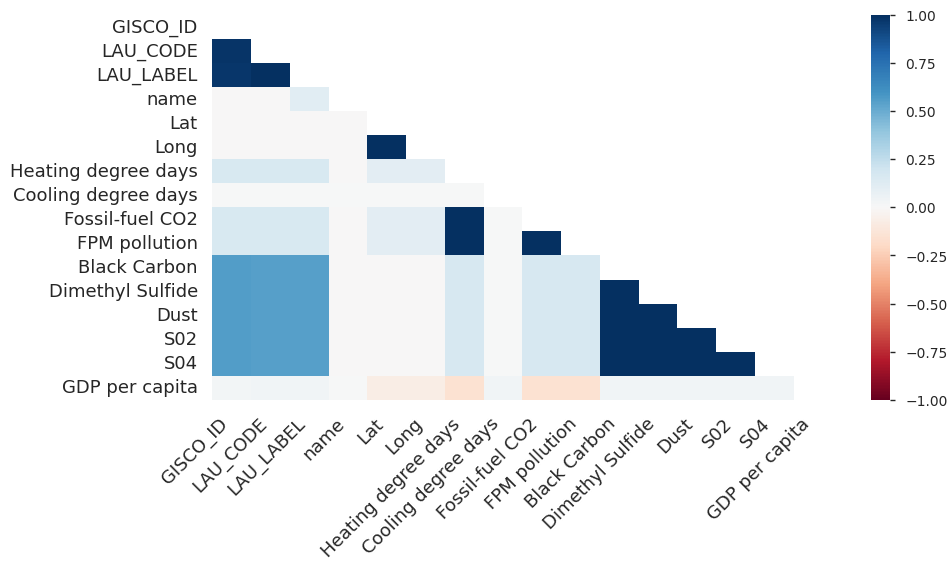

In [ ]:
# Profile report for dataset without emissions data (df2) 
profile = ProfileReport(df2)
profile.to_file("df2_data_report_.html")

<Axes: >

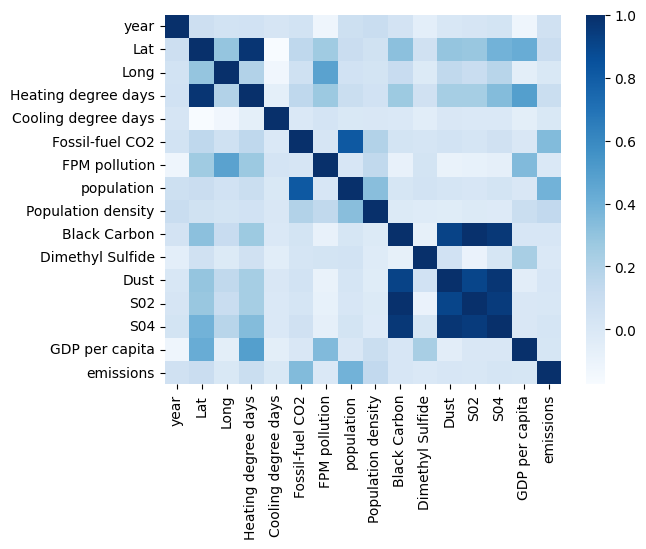

In [ ]:
#calculate the correlation matrix on the numeric columns
corr = df1.select_dtypes('number').corr()

sb.heatmap(corr, cmap="Blues")


In [ ]:
 # Create correlation matrix 
corr_mat = df1.corr(method='pearson', numeric_only= True) 
  
# Retain upper triangular values of correlation matrix and 
# make Lower triangular values Null 
upper_corr_mat = corr_mat.where( 
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool)) 
  
# Convert to 1-D series and drop Null values and sort 
unique_corr_pairs = upper_corr_mat.unstack().dropna().sort_values() 
unique_corr_pairs_last10 = unique_corr_pairs.tail(10)

print(unique_corr_pairs_last10)

FPM pollution        Long                   0.473531
GDP per capita       Heating degree days    0.492538
population           Fossil-fuel CO2        0.813782
S02                  Dust                   0.905054
Dust                 Black Carbon           0.917347
S04                  S02                    0.945957
                     Black Carbon           0.961059
                     Dust                   0.969168
Heating degree days  Lat                    0.974579
S02                  Black Carbon           0.992160
dtype: float64


## 3.3 Preprocessing Data: dataset with reported emissions data (df1)  

In [6]:
# Creating variable: emissions per capita 
df1['emissions_per_capita'] = df1['emissions']/ df1['population']


In [7]:
# Creating taget variable: dummy variable (above/ below twice the world average emissions)

# Define the function to categorise emissions per capita based on world average (2*5.15 tCO2 per capita) 
def categorise_emissions(emissions):
    if emissions >= 10.3:
        return 1
    else:
        return 0

# Apply the function to the missions_per_capita column using the apply() function
df1['high_emissions'] = df1['emissions_per_capita'].apply(categorise_emissions)

# Print the resulting dataframe
df1.head()



,GISCO_ID,LAU_CODE,LAU_LABEL,name,iso,country,year,Lat,Long,Heating degree days,...,Population density,Black Carbon,Dimethyl Sulfide,Dust,S02,S04,GDP per capita,emissions,emissions_per_capita,high_emissions
0,AL_AL224,AL224,TiranÃ«,Tirana,ALB,Albania,2011,41.330000,19.82,919.432288,...,483.082777,0.112815,0.996688,4.972912,0.214391,1.859574,12836.54051,681448.0,1.267538,0
1,AT_20101,20101,Klagenfurt am WÃ¶rthersee,Klagenfurt,AUT,Austria,2011,46.620000,14.31,3533.581680,...,757.160718,0.073485,0.293214,1.660604,0.353672,0.827747,37480.45703,1027134.0,11.244493,1
2,AT_31715,31715,Laxenburg,Laxenburg,AUT,Austria,2008,48.070000,16.36,4198.085425,...,293.503999,0.114267,0.077736,3.846727,0.819903,1.510525,36634.12109,21504.0,7.076489,0
3,AT_31715,31715,Laxenburg,Laxenburg,AUT,Austria,2014,48.070000,16.36,4250.559937,...,298.653734,0.167375,0.093484,3.671484,0.785424,1.639452,36582.01563,19648.0,6.354227,0
4,AT_31943,31943,Traismauer,Lower Austria,AUT,Austria,2005,48.333333,15.75,4357.967133,...,140.655104,0.128829,0.084922,3.318044,0.787181,1.691685,33176.00781,12954000.0,2247.916175,1


In [38]:
print(df1['high_emissions'].value_counts()[1])

539


In [39]:
print(df1['high_emissions'].value_counts()[0])

7185


In [40]:
# Identify missing data: dataset with reported emissions data (df1)
print(df1.isna().sum().sort_values())

high_emissions            0
emissions                 0
iso                       0
country                   0
year                      0
name                      1
population                4
emissions_per_capita      4
Heating degree days       9
Fossil-fuel CO2          21
Population density       22
Lat                      29
Long                     29
GDP per capita           35
Black Carbon             46
Dimethyl Sulfide         46
Dust                     46
S02                      46
S04                      46
LAU_CODE                 53
GISCO_ID                 53
LAU_LABEL                54
Cooling degree days     121
FPM pollution           121
dtype: int64


- replace missing data with means during data preprocessing

In [8]:
# Data splitting
# Step 1:splitting features variables and target variable and return a Numpy representation of the DataFrame
X = df1.drop(["GISCO_ID", "LAU_CODE", "LAU_LABEL", "name", "iso", "country","year","emissions","emissions_per_capita",  "high_emissions","GDP per capita", "Cooling degree days"], axis= 1).values
y = df1["high_emissions"].values
# Step 2: Splitting features variables and target variable into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [9]:
# Imputation with scikit-learn: training data and test data 
imp_num = SimpleImputer ()
X_train = imp_num.fit_transform(X_train)
X_test = imp_num.transform(X_test) 

In [10]:
# Scaling feature variables of training and test data
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

print(np.mean(X_train), np.std(X_train))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

8765.847378564806 108383.21428858125
7.045247603857496e-16 1.0000000000000024


## 3.4 Preprocessing Data: dataset without reported emissions data (df2)  

In [44]:
# Identify missing values 
print(df2.isna().sum().sort_values())

iso                       0
country                   0
year                      0
Population density        0
population                0
name                      1
Lat                      35
Long                     35
LAU_CODE                 81
LAU_LABEL                82
GISCO_ID                 84
Dust                     91
Dimethyl Sulfide         91
Black Carbon             91
S04                      91
S02                      91
Fossil-fuel CO2        2273
FPM pollution          2273
Heating degree days    2273
GDP per capita         7049
Cooling degree days    7943
emissions              7944
dtype: int64


- remove rows where data on "Fossil-fuel CO2" is missing during data preprocessing 
- remove variables GDP per capita, Cooling degree days and emissions from feature variables of predictions models (not enough data available to base predictions on it) during data preprocessing
- replace missing data with means during data preprocessing for any other variables 

In [11]:
# Creating NumpyArray from dataset 
X_new = df2.drop(["GISCO_ID", "LAU_CODE", "LAU_LABEL", "name", "iso", "country","year","emissions","GDP per capita", "Cooling degree days"], axis= 1).values

In [12]:
# Imputation with scikit-learn
imp_num = SimpleImputer ()
X_new = imp_num.fit_transform(X_new)


In [13]:
# Scaling x_new
scaler = StandardScaler()
X_new_scaled= scaler.fit_transform(X_new) 
X_new_scaled = scaler.transform(X_new)
print(np.mean(X_new), np.std(X_new))
print(np.mean(X_new_scaled), np.std(X_new_scaled))

6270.035953263276 71751.7376756903
-3.130538236606685e-18 1.0


In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_new.shape)

(6179, 12)
(6179,)
(1545, 12)
(1545,)
(7944, 12)


# 4. Data Modeling

## 4.1 Decision Tree

### 4.1.1 Model fine-tuning

In [14]:
# Set seed to 1 for reproducibility
SEED = 123
# Instantiate a DecisionTreeClassifier 'dt'
dt = DecisionTreeClassifier(random_state=SEED)
# Print out 'dt's hyperparameters
print(dt.get_params())   

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}


In [ ]:
# Define the grid of hyperparameters 'params_dt'
params_dt = {
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [40,50,60,70,80,90],
    'max_features': [2, 5, 10, 20,25,30,40,50,60,70,80,90],
    'max_depth': [1,2,10, 20, 30, None],
    'criterion':['gini','entropy']}

In [ ]:
# Instantiate a 5-fold CV grid search object 'grid_dt', based on precision (low false positives) (Genauigkeit)
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,                       
                       scoring='precision',                                              
                       cv=5,                       
                       n_jobs=-1)

In [ ]:
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 10, 20, 30, None],
                         'max_features': [2, 5, 10, 20, 25, 30, 40, 50, 60, 70,
                                          80, 90],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [40, 50, 60, 70, 80, 90]},
             scoring='precision')

In [ ]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 70}


In [ ]:
# Extract best model from 'grid_dt'
best_model = grid_dt.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test_scaled,y_test)
# Print test set accuracy
print("Test set accuracy of best model: {:.3f}".format(test_acc))

Test set accuracy of best model: 0.924


### 4.1.3 Model fitting and testing

In [50]:
# Instantiate untuned Decision Tree Classifier
dt_untuned = DecisionTreeClassifier(random_state=SEED)

 # Fit the classifier to the training set 
dt_untuned.fit(X_train_scaled, y_train) 

# Predict the labels of the test set
y_pred_dt_untuned = dt_untuned.predict(X_test_scaled) 

In [51]:
# # Instantiate tuned Decision Tree Classifiert using the best parameter from above
dt_tuned=DecisionTreeClassifier(criterion = 'gini', max_depth= 10, max_features= 2, min_samples_leaf= 2, min_samples_split= 70,random_state=SEED)

 # Fit the classifier to the training set 
dt_tuned.fit(X_train_scaled, y_train)

# Predict the labels of the test set
y_pred_dt_tuned=dt_tuned.predict(X_test_scaled)

### 4.1.3 Assessing model performance

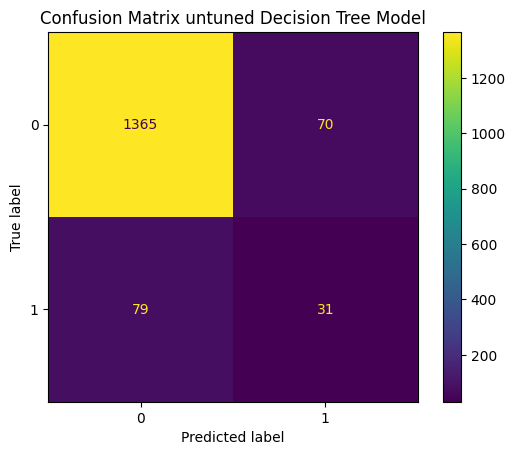

In [ ]:
# Model performance for untuned Decision Tree model 
cm_dt_untuned = confusion_matrix(y_test, y_pred_dt_untuned, labels=dt_untuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt_untuned,
                              display_labels=dt_untuned.classes_)
disp.plot()
plt.title('Confusion Matrix untuned Decision Tree Model')
plt.show()

- total of y_test = 1545 
- True positive: 31 (predicted to be high emissions city and actually being high emissions city) 
- False positive: 70 (predicted to be high emissions city but actually being low emissions city) 
- True negative: 1365 (predicted to be low emissions city and actually being low emissions city)
- False negative: 79 (predicted to be low emissions city but actually being high emissions city)

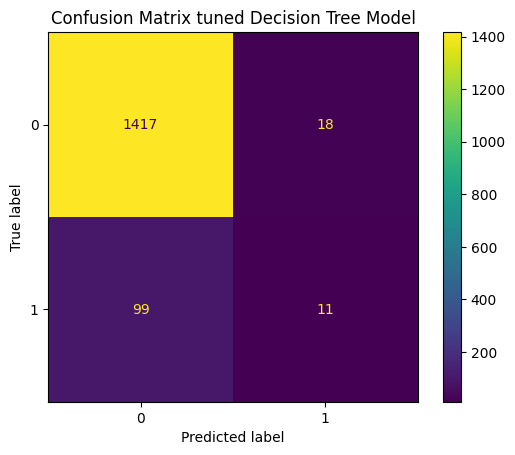

In [ ]:
# Model performance for tuned Decision Tree model 
cm_dt_tuned = confusion_matrix(y_test, y_pred_dt_tuned, labels=dt_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt_tuned,
                              display_labels=dt_tuned.classes_)
disp.plot()
plt.title('Confusion Matrix tuned Decision Tree Model')
plt.show()

- total of y_test = 1545 
- True positive:   11 (predicted to be high emissions city and actually being high emissions city) 
- False positive:  18 (predicted to be high emissions city but actually being low emissions city) 
- True negative: 1417 (predicted to be low emissions city and actually being low emissions city)
- False negative: 99 (predicted to be low emissions city but actually being high emissions city)

 

In [ ]:
# Print Classification Report for untuned Decision Tree model 
print(classification_report(y_test, y_pred_dt_untuned))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1435
           1       0.31      0.28      0.29       110

    accuracy                           0.90      1545
   macro avg       0.63      0.62      0.62      1545
weighted avg       0.90      0.90      0.90      1545



- Accuracy for testing dataset before tuning : 90% 
- Precision for prediction of high emissions cities: 31% -> percentage of predicted high emissions cities to be actual high emissions cities 
- Recall for prediction of high emissions cities: 28% -> 16% of the high emissions cities in the testing data set where correctly identified 
- F1-Score for prediction of high emission cities: 29%

In [ ]:
# Print Classification Report for tuned Decision Tree model 
print(classification_report(y_test, y_pred_dt_tuned))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1435
           1       0.38      0.10      0.16       110

    accuracy                           0.92      1545
   macro avg       0.66      0.54      0.56      1545
weighted avg       0.90      0.92      0.90      1545



- Accuracy for testing dataset after tuning : 92% 
- Precision for prediction of high emissions cities: 38% -> percentage of predicted high emissions cities to be actual high emissions cities (rather low false positive rate) 
- Recall for prediction of high emissions cities: 10% -> 16% of the high emissions cities in the testing data set where correctly identified 
- F1-Score for prediction of high emission cities: 16%


In [ ]:
# calculate AUC scores for untuned Decision Tree-Model 
dt_auc_untuned = roc_auc_score(y_test, y_pred_dt_untuned)
# summarize scores
print('Untuned Decision Tree Model: ROC AUC=%.3f' % (dt_auc_untuned))


Untuned Decision Tree Model: ROC AUC=0.617


In [ ]:
# calculate AUC scores for tuned Decision Tree-Model 
knn_auc_tuned = roc_auc_score(y_test, y_pred_dt_tuned)
# summarize scores
print('Tuned Decision Tree: ROC AUC=%.3f' % (knn_auc_tuned))

Tuned Decision Tree: ROC AUC=0.544


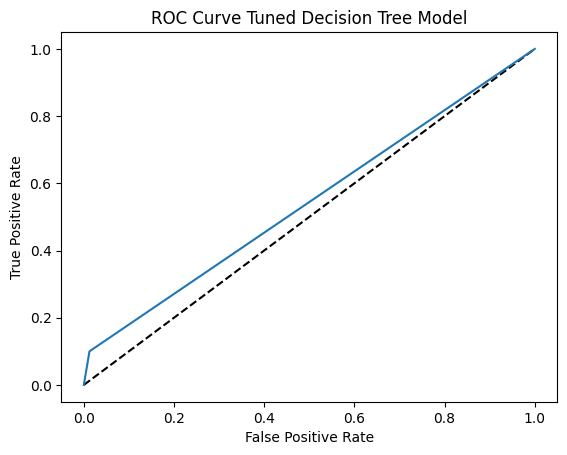

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt_tuned)


plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Tuned Decision Tree Model')
plt.show()

### 4.1.4 Visualizing model

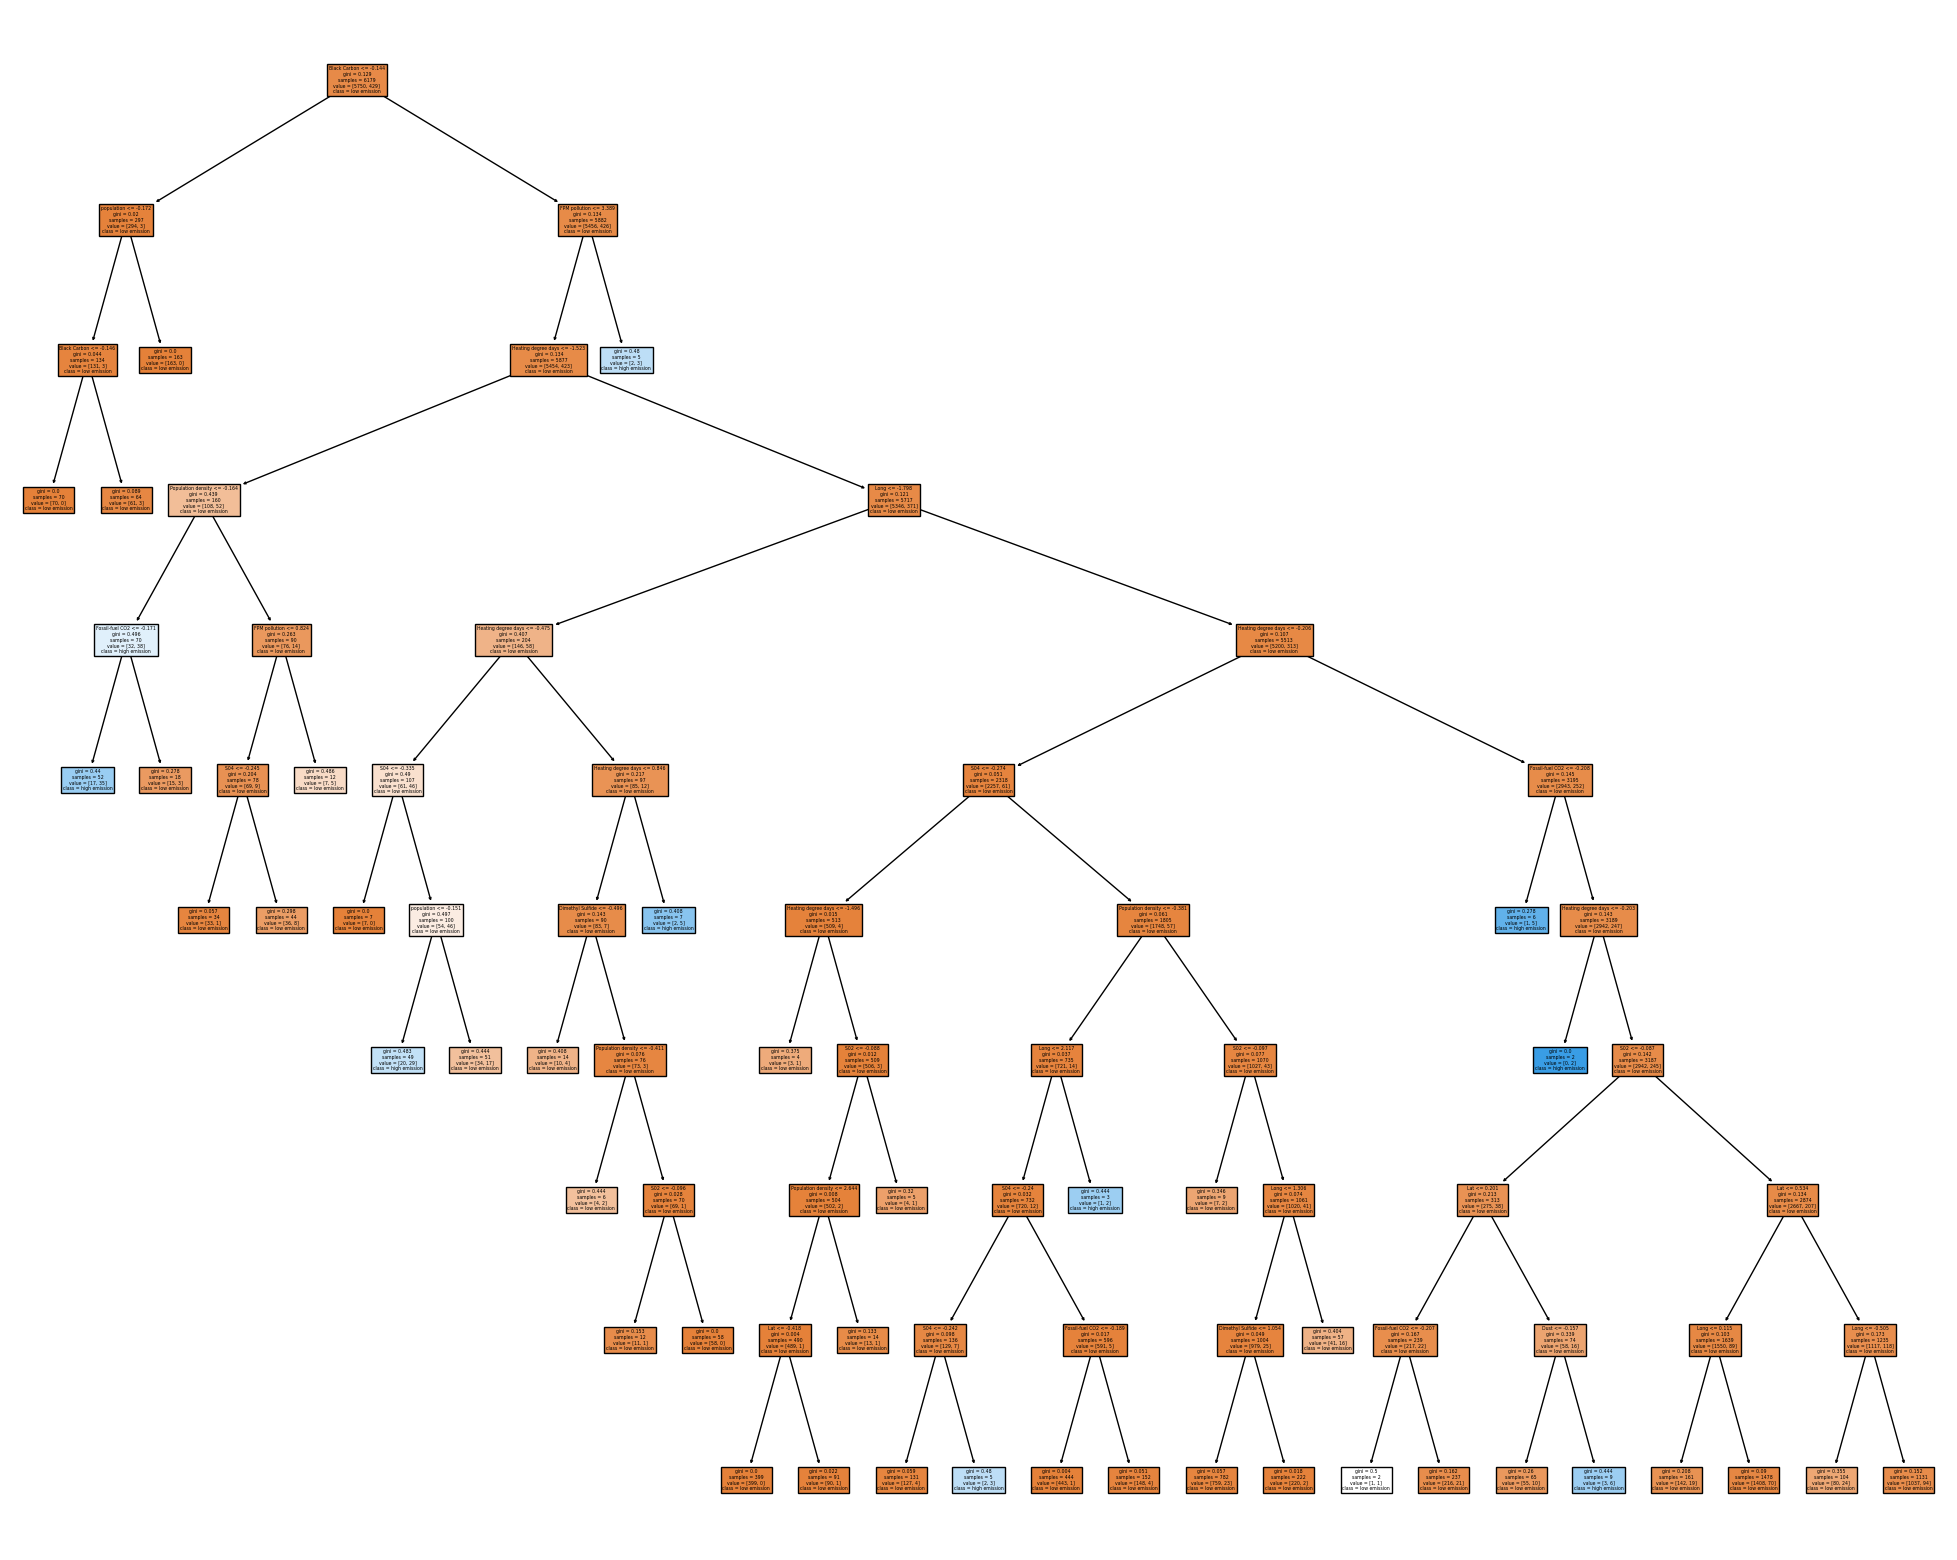

In [ ]:

# Putting the feature names and class names into variables
fn = ['Lat', 'Long', 'Heating degree days','Fossil-fuel CO2', 'FPM pollution', 'population', 'Population density',
       'Black Carbon', 'Dimethyl Sulfide', 'Dust', 'S02', 'S04']
cn = [ 'low emission','high emission']

fig1 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_tuned, feature_names=fn, class_names=cn,
                    filled=True)

# Create Output folder
os.makedirs('output', exist_ok=True)  

# Export decision tree
fig1.savefig("output/DT_model_tree.pdf")

## 4.2 Extreme Gradient Boosting with XGBoost 

### 4.2.1 Model fine-tuning

In [ ]:
# Instantiate the model:  XGBClassifier

model = xgb.XGBClassifier() 
params = {
    'n_estimators':  np.arange(50, 200, 50),
    'learning_rate': [0.01,0.05,0.1], 
    'gamma': [0, 0.5, 1],
    'colsample_bytree': [0, 0.5, 1],               
    'reg_lambda': [0.5, 1, 5,10], 
    'reg_alpha': [0.5, 1, 5,10], 
}

gs = GridSearchCV(model, params, n_jobs=-1, cv=KFold(n_splits=5), scoring='precision')
gs.fit(X_train_scaled, y_train)



GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0, 0.5, 1], 'gamma': [0, 0.5, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': array([ 50, 100, 150]),
                         'reg_alpha': [0.5, 1, 5, 10],
                         'reg_lambda': [0.5, 1, 5, 10]},
             scoring='precision')

In [ ]:
print('Best ROC AUC score:', gs.best_score_)
print('Best params:', gs.best_params_)

Best ROC AUC score: 0.8761904761904763
Best params: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1}


### 4.2.2 Model fitting and testing

In [19]:
# Instantiate untuned XGBClassifier
xgb_cl_untuned = xgb.XGBClassifier(seed = 123)  

 # Fit the classifier to the training set 
xgb_cl_untuned.fit(X_train_scaled, y_train) 

# Predict the labels of the test set: y_pred_xgb 
y_pred_xgb_untuned = xgb_cl_untuned.predict(X_test_scaled) 

In [20]:
# Instantiate the XGBClassifier with the above identified hyperparameters  
xgb_cl_tuned = xgb.XGBClassifier(colsample_bytree = 1, gamma = 0, learning_rate= 0.01, n_estimators= 100, reg_lambda= 1, re_alpha=0.5,seed = 123)  

 
# Fit the classifier to the training set 
xgb_cl_tuned.fit(X_train_scaled, y_train) 

# Predict the labels of the test set: y_pred_xgb 
y_pred_xgb_tuned = xgb_cl_tuned.predict(X_test_scaled) 




### 4.2.3 Assessing model performance

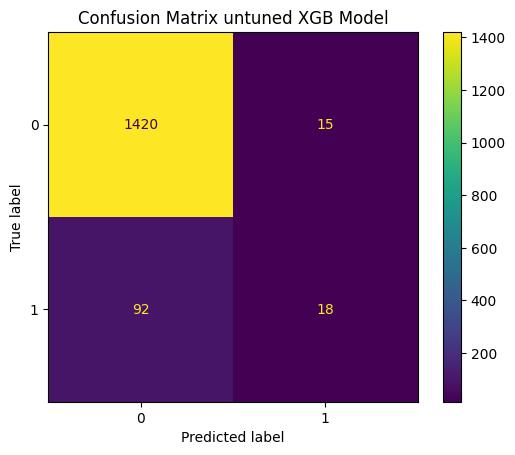

In [ ]:
# Model performance for untuned xgbmodel 
cm_xgb_untuned = confusion_matrix(y_test, y_pred_xgb_untuned, labels=xgb_cl_untuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_untuned,
                              display_labels=xgb_cl_untuned.classes_)
disp.plot()
plt.title('Confusion Matrix untuned XGB Model')
plt.show()

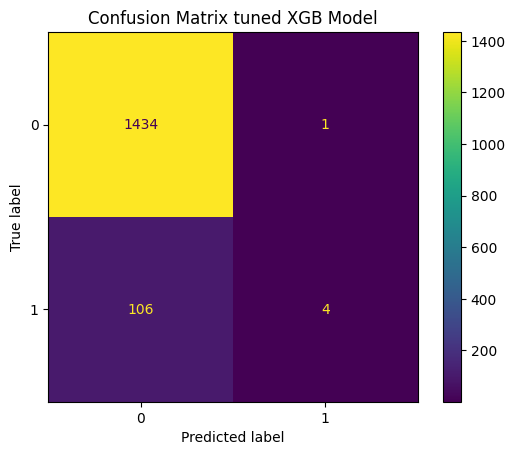

In [ ]:
# Model performance for tuned xgbmodel 
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned, labels=xgb_cl_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_tuned,
                              display_labels=xgb_cl_tuned.classes_)
disp.plot()
plt.title('Confusion Matrix tuned XGB Model')
plt.show()

In [ ]:
# Print Classification Report for untuned XGB model 
print(classification_report(y_test, y_pred_xgb_untuned))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1435
           1       0.55      0.16      0.25       110

    accuracy                           0.93      1545
   macro avg       0.74      0.58      0.61      1545
weighted avg       0.91      0.93      0.91      1545



- Accuracy for testing dataset before tuning : 93% 
- Precision for prediction of high emissions cities: 55% -> percentage of predicted high emissions cities to be actual high emissions cities (rather low false positive rate) 
- Recall for prediction of high emissions cities: 16% -> 16% of the high emissions cities in the testing data set where correctly identified 
- F1-Score for prediction of high emission cities:25%

In [ ]:
# Print Classification Report for tuned XGB model 
print(classification_report(y_test, y_pred_xgb_tuned))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1435
           1       0.80      0.04      0.07       110

    accuracy                           0.93      1545
   macro avg       0.87      0.52      0.52      1545
weighted avg       0.92      0.93      0.90      1545



- Accuracy for testing dataset after tuning : 93% 
- Precision for prediction of high emissions cities: 80% -> percentage of predicted high emissions cities to be actual high emissions cities (rather low false positive rate) 
- Recall for prediction of high emissions cities: 4% -> 4% of the high emissions cities in the testing data set where correctly identified 
- F1-Score for prediction of high emission cities:7%

In [ ]:
# calculate AUC scores for untuned XGB model
xgb_auc = roc_auc_score(y_test, y_pred_xgb_untuned)
# summarize scores
print('Untuned XGB: ROC AUC: %.3f' % (xgb_auc))


Untuned XGB: ROC AUC: 0.577


In [ ]:
# calculate AUC scores for tuned XGB model
xgb_auc = roc_auc_score(y_test, y_pred_xgb_tuned)
# summarize scores
print('Tuned XGB: ROC AUC: %.3f' % (xgb_auc))

Tuned XGB: ROC AUC: 0.518


XGB: ROC AUC=0.518


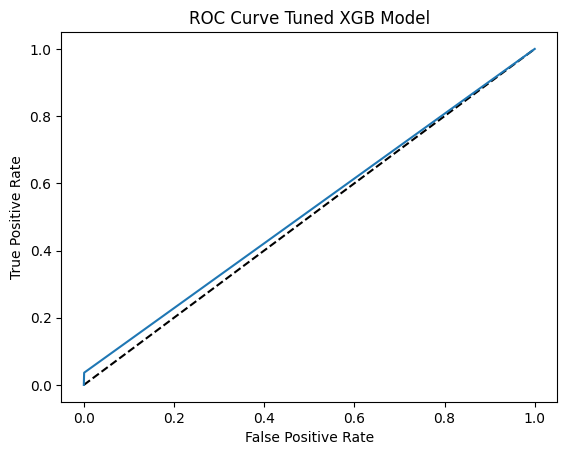

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_tuned)

# summarize scores
print('XGB: ROC AUC=%.3f' % (xgb_auc))

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Tuned XGB Model')
plt.show()

In [ ]:
dump_list_xgb_untuned = xgb_cl_untuned.get_booster().get_dump()
num_trees_xgb_untuned = len(dump_list_xgb_untuned)
print(num_trees_xgb_untuned)

100


In [ ]:
dump_list_xgb_tuned = xgb_cl_tuned.get_booster().get_dump()
num_trees_xgb_tuned = len(dump_list_xgb_tuned)
print(num_trees_xgb_tuned)

100


### 4.2.4 Visualizing model

<Axes: >

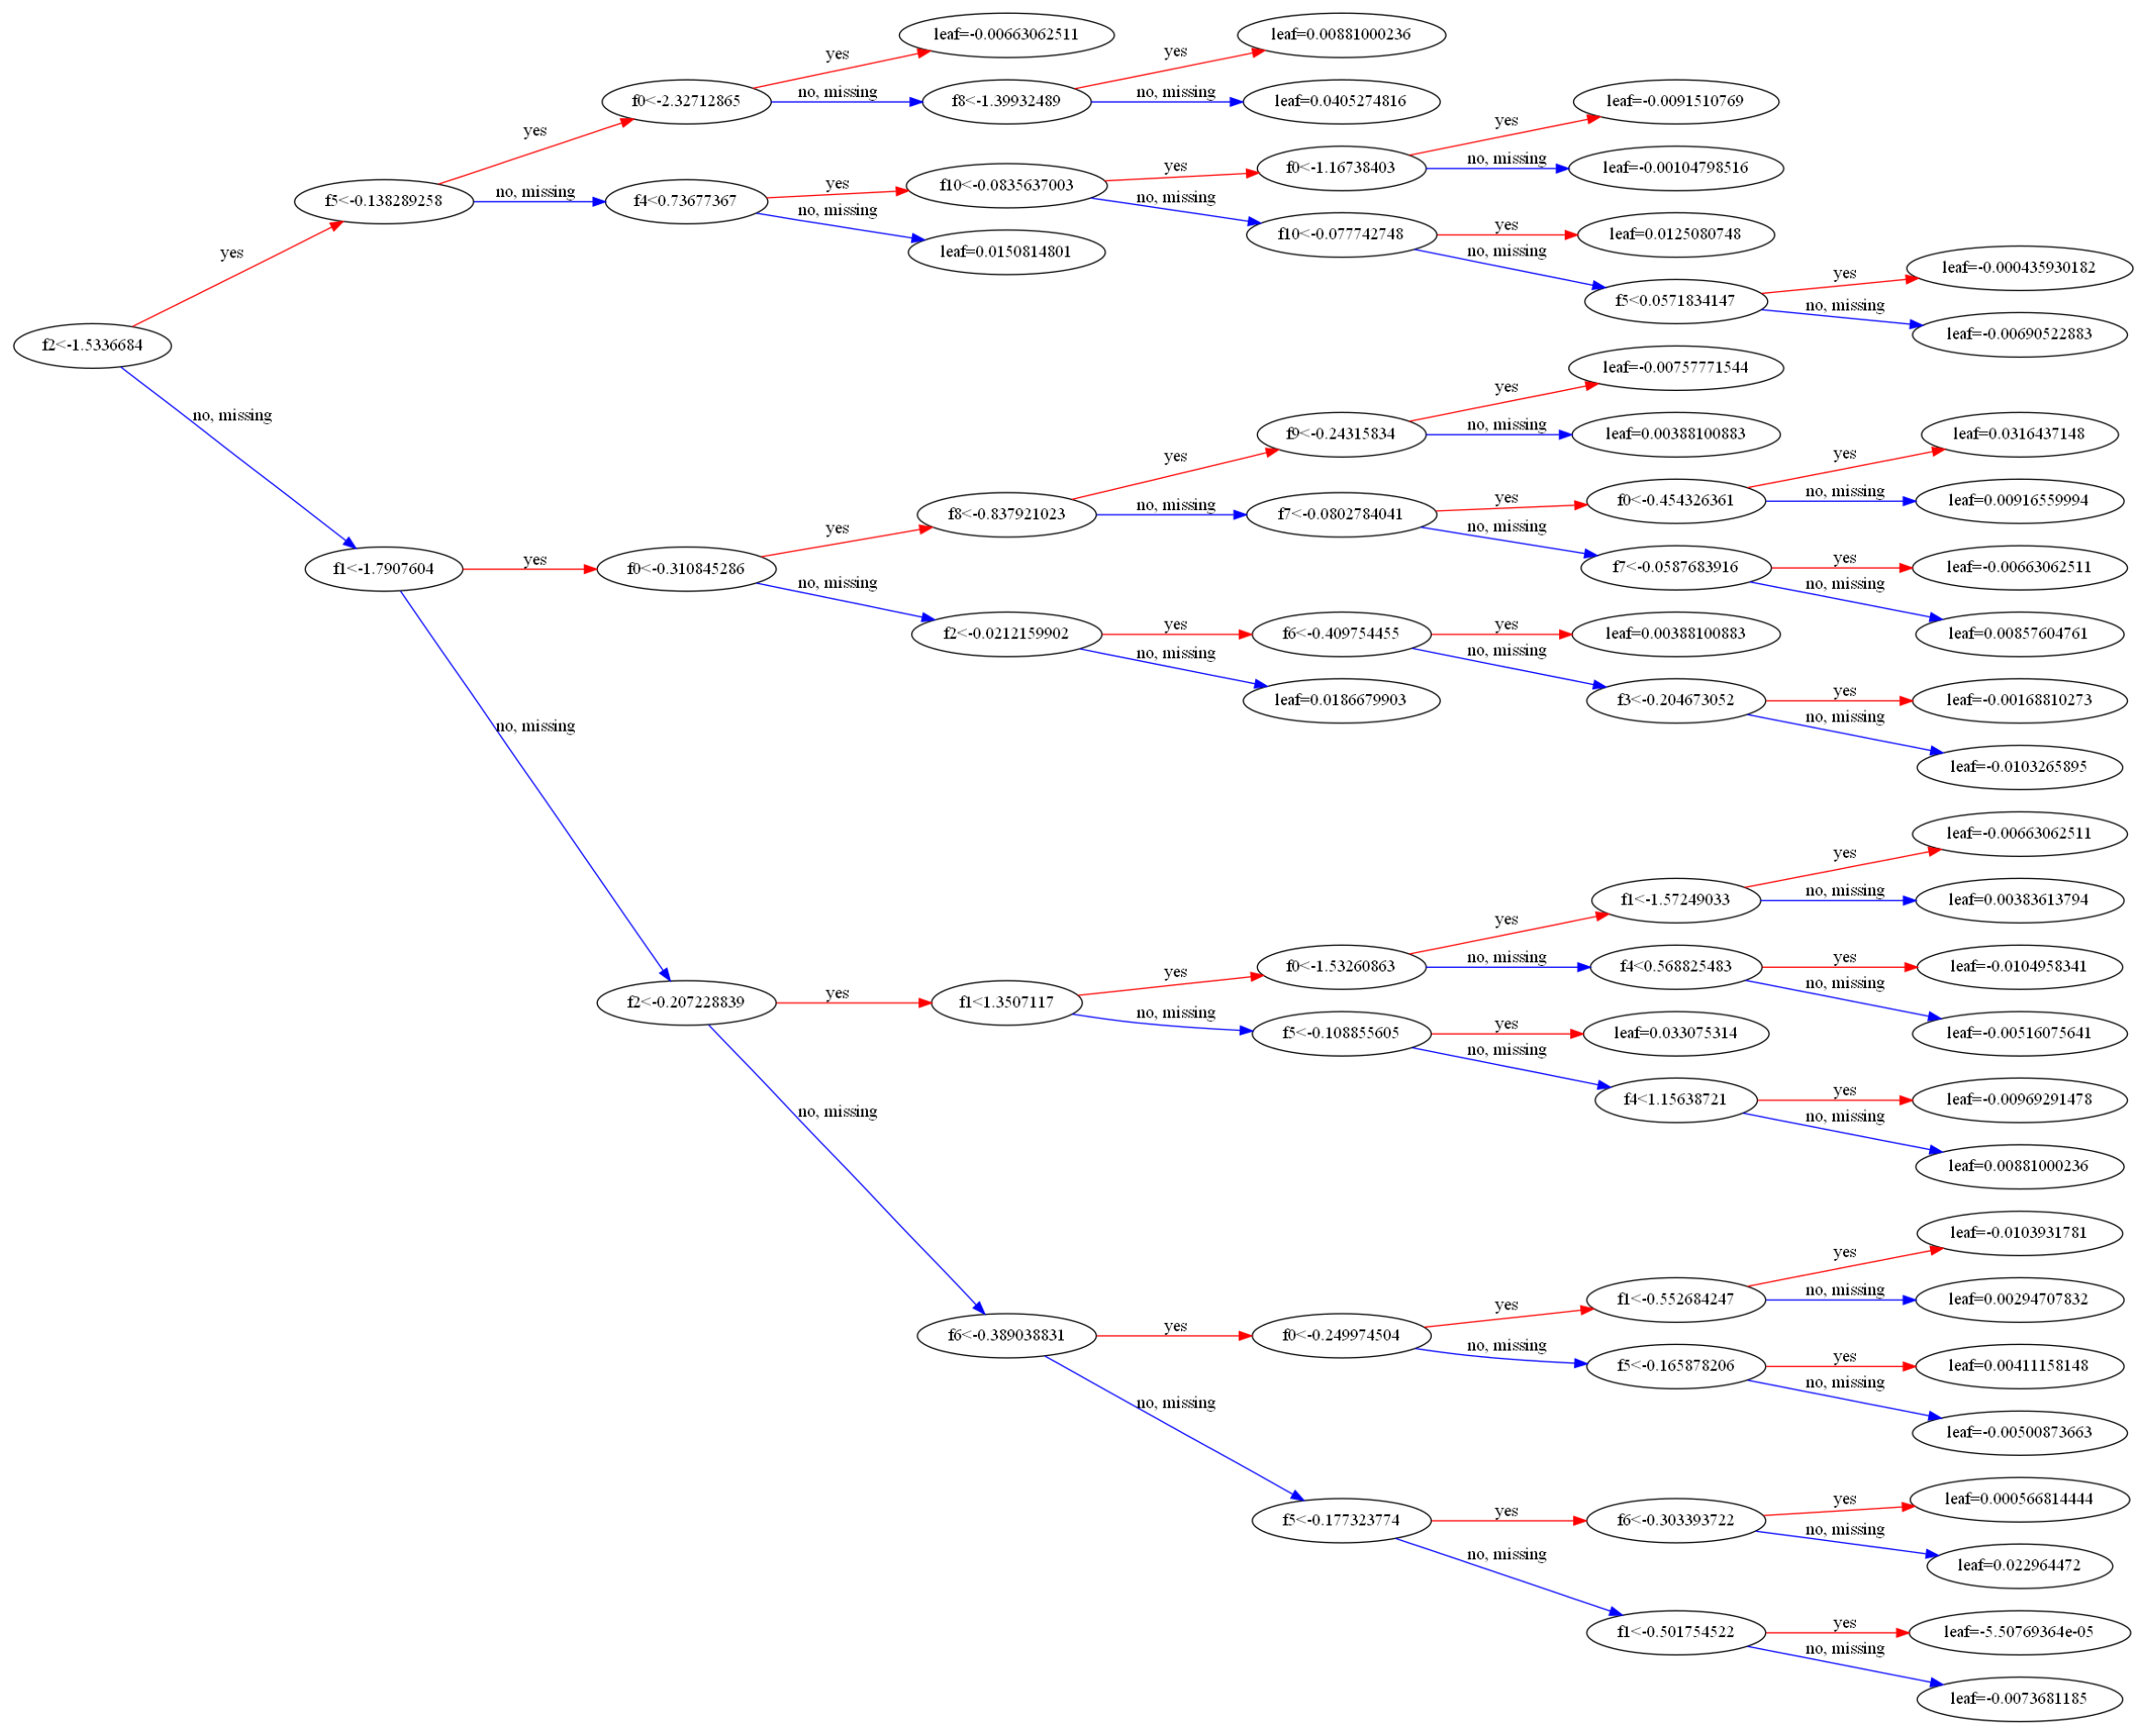

In [31]:
# Plot first tree of XGB model 
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(booster=xgb_cl_tuned, num_trees=0, rankdir="LR", ax=ax)

## 4.3 Evaluating classification Models 

In [ ]:
# Calculating corss validation perfoarmance of models 
kf = KFold(n_splits=6, random_state=42, shuffle=True)

#Recall
Recall_dt_untuned= cross_val_score(dt_untuned, X_train_scaled, y_train, cv=kf, scoring= "recall").mean()
Recall_dt_tuned= cross_val_score(dt_tuned, X_train_scaled, y_train, cv=kf, scoring= "recall").mean()
Recall_xgb_untuned= cross_val_score(xgb_cl_untuned, X_train_scaled, y_train, cv=kf, scoring= "recall").mean()
Recall_xgb_tuned= cross_val_score(xgb_cl_tuned, X_test_scaled, y_test, cv=kf, scoring= "recall").mean()
#Accuracy
acc_dt_untuned= cross_val_score(dt_untuned, X_train_scaled, y_train, cv=kf).mean()
acc_dt_tuned= cross_val_score(dt_tuned, X_train_scaled, y_train, cv=kf).mean()
acc_xgb_untuned= cross_val_score(xgb_cl_untuned, X_train_scaled, y_train, cv=kf).mean()
acc_xgb_tuned= cross_val_score(xgb_cl_tuned, X_train_scaled, y_train, cv=kf).mean()
#F1-Score
f1_dt_untuned= cross_val_score(dt_untuned,X_train_scaled, y_train, cv=kf, scoring= "f1").mean()
f1_dt_tuned= cross_val_score(dt_tuned,X_train_scaled, y_train, cv=kf, scoring= "f1").mean()
f1_xgb_untuned= cross_val_score(xgb_cl_untuned, X_train_scaled, y_train, cv=kf, scoring= "f1").mean()
f1_xgb_tuned= cross_val_score(xgb_cl_tuned, X_train_scaled, y_train, cv=kf, scoring= "f1").mean()
#Precision
Precision_dt_untuned= cross_val_score(dt_untuned, X_train_scaled, y_train, cv=kf, scoring= "precision").mean()
Precision_dt_tuned= cross_val_score(dt_tuned, X_train_scaled, y_train, cv=kf, scoring= "precision").mean()
Precision_xgb_untuned= cross_val_score(xgb_cl_untuned, X_train_scaled, y_train, cv=kf, scoring= "precision").mean()
Precision_xgb_tuned= cross_val_score(xgb_cl_tuned, X_train_scaled, y_train, cv=kf, scoring= "precision").mean()
#ROC AUC 
rocauc_dt_untuned= cross_val_score(dt_untuned, X_train_scaled, y_train, cv=kf, scoring= "roc_auc").mean()
rocauc_dt_tuned= cross_val_score(dt_tuned, X_train_scaled, y_train, cv=kf, scoring= "roc_auc").mean()
rocauc_xgb_untuned= cross_val_score(xgb_cl_untuned, X_train_scaled, y_train, cv=kf, scoring= "roc_auc").mean()
rocauc_xgb_tuned= cross_val_score(xgb_cl_tuned, X_train_scaled, y_train, cv=kf, scoring= "roc_auc").mean()

# Print results
print('ACCURACY')
print('Mean Accuracy-Score for untuned Decision Tree-modell after cross validation = %.3f' % (acc_dt_untuned))
print('Mean Accuracy-Score for tuned Decision Tree-modell after cross validation = %.3f' % (acc_dt_tuned))
print('Mean Accuracy-Score for untuned XGB-modell after cross validation = %.3f' % (acc_xgb_untuned))
print('Mean Accuracy-Score for tuned XGB-modell after cross validation = %.3f' % (acc_xgb_tuned))
print("F1-SCORE")
print('Mean F1-Score for untuned Decision Tree-modell after cross validation = %.3f' % (f1_dt_untuned))
print('Mean F1-Score for tuned Decision Tree-modell after cross validation = %.3f' % (f1_dt_tuned))
print('Mean F1-Score for untuned XGB-modell after cross validation = %.3f' % (f1_xgb_untuned))
print('Mean F1-Score for tuned XGB-modell after cross validation = %.3f' % (f1_xgb_tuned))
print('RECALL')
print('Mean Recall-Score for untuned Decision Tree-modell after cross validation = %.3f' % (Recall_dt_untuned))
print('Mean Recall-Score for tuned Decision Tree-modell after cross validation = %.3f' % (Recall_dt_tuned))
print('Mean Recall-Score for untuned XGB-modell after cross validation = %.3f' % (Recall_xgb_untuned))
print('Mean Recall-Score for tuned XGB-modell after cross validation = %.3f' % (Recall_xgb_tuned))
print('PRECISION')
print('Mean Precision-Score for untuned Decision Tree-modell after cross validation = %.3f' % (Precision_dt_untuned))
print('Mean Precision-Score for tuned Decision Tree-modell after cross validation = %.3f' % (Precision_dt_tuned))
print('Mean Precision-Score for untuned XGB-modell after cross validation = %.3f' % (Precision_xgb_untuned))
print('Mean Precision-Score for tuned XGB-modell after cross validation = %.3f' % (Precision_xgb_tuned))
print('AUC-ROC')
print('Mean AUC-ROC for untuned Decision Tree-modell after cross validation = %.3f' % (rocauc_dt_untuned))
print('Mean AUC-ROC for tuned Decision Tree-modell after cross validation = %.3f' % (rocauc_dt_tuned))
print('Mean AUC-ROC for untuned XGB-modell after cross validation = %.3f' % (rocauc_xgb_untuned))
print('Mean AUC-ROC for tuned XGB-modell after cross validation = %.3f' % (rocauc_xgb_tuned))


ACCURACY
Mean Accuracy-Score for untuned Decision Tree-modell after cross validation = 0.895
Mean Accuracy-Score for tuned Decision Tree-modell after cross validation = 0.928
Mean Accuracy-Score for untuned XGB-modell after cross validation = 0.934
Mean Accuracy-Score for tuned XGB-modell after cross validation = 0.933
F1-SCORE
Mean F1-Score for untuned Decision Tree-modell after cross validation = 0.296
Mean F1-Score for tuned Decision Tree-modell after cross validation = 0.116
Mean F1-Score for untuned XGB-modell after cross validation = 0.320
Mean F1-Score for tuned XGB-modell after cross validation = 0.099
RECALL
Mean Recall-Score for untuned Decision Tree-modell after cross validation = 0.320
Mean Recall-Score for tuned Decision Tree-modell after cross validation = 0.070
Mean Recall-Score for untuned XGB-modell after cross validation = 0.226
Mean Recall-Score for tuned XGB-modell after cross validation = 0.011
PRECISION
Mean Precision-Score for untuned Decision Tree-modell after c

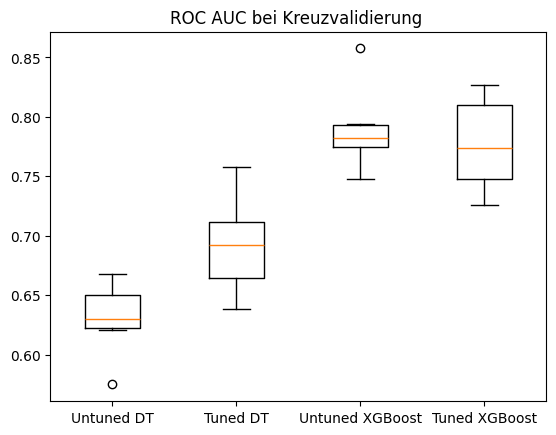

In [ ]:
models = {"Untuned DT": dt_untuned, "Tuned DT": dt_tuned, "Untuned XGBoost": xgb_cl_untuned, "Tuned XGBoost": xgb_cl_tuned}

results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring= "roc_auc")
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.title('ROC AUC bei Kreuzvalidierung ')
plt.show()

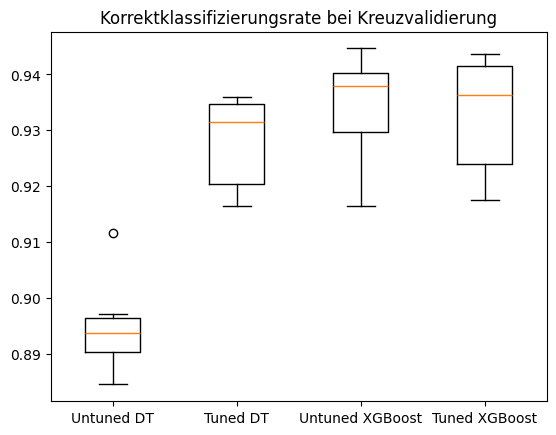

In [ ]:
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.title('Korrektklassifizierungsrate bei Kreuzvalidierung')
plt.show()

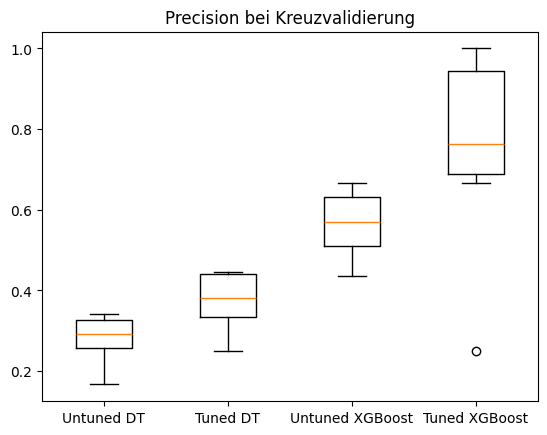

In [ ]:
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring = 'precision')
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.title('Precision bei Kreuzvalidierung')
plt.show()

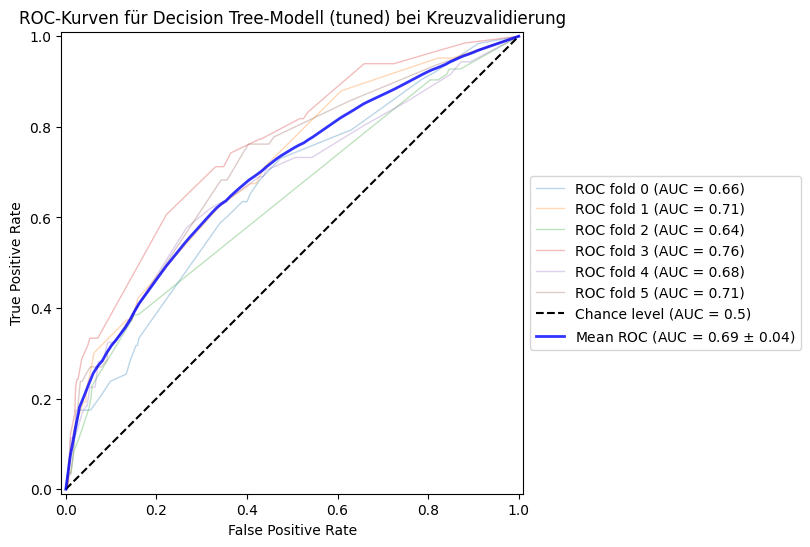

In [ ]:
X= X_train_scaled
y= y_train
cv = kf
classifier1 = dt_tuned
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
n_splits = 6

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier1.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier1,
        X[test],
        y[test],
        alpha=0.3,
        name=f"ROC fold {fold}",
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=('ROC-Kurven für Decision Tree-Modell (tuned) bei Kreuzvalidierung'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

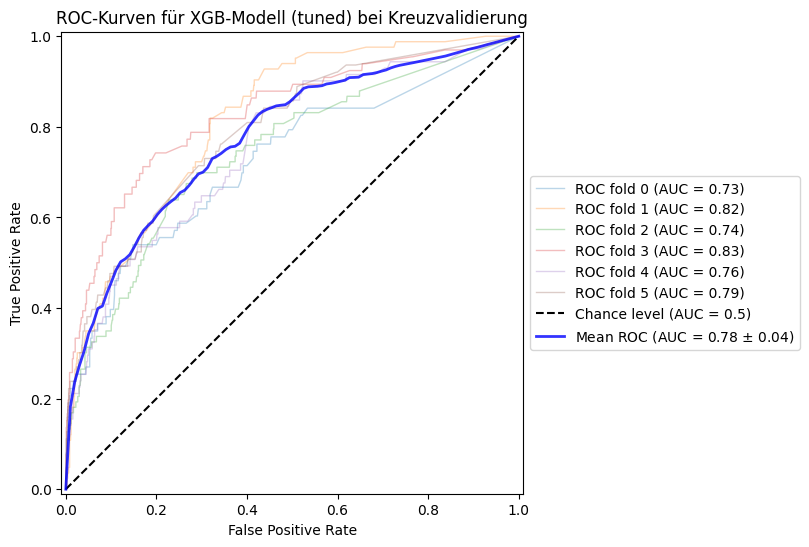

In [ ]:
X= X_train_scaled
y= y_train
cv = kf
classifier2 = xgb_cl_tuned
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
n_splits = 6

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier2.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier2,
        X[test],
        y[test],
        alpha=0.3,
        name=f"ROC fold {fold}",
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=('ROC-Kurven für XGB-Modell (tuned) bei Kreuzvalidierung'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 4.4 Model apllication

### 4.4.1 Applying Decision Tree-Model

In [ ]:
# Predict the labels for the X_new (based on untuned model)
y_new_dt = dt_tuned.predict(X_new_scaled)

# Count predictions 
num_zeros_dt = (y_new_dt == 0).sum()
num_ones_dt = (y_new_dt == 1).sum()

# Print the numbers of predictions 
print("Number of predicted high emmissions cites according to Decision Tree-model: {}".format(num_ones_dt)) 
print("Number of predicted lower emmissions cites according to Decision Tree-model: {}".format(num_zeros_dt))   

Number of predicted high emmissions cites according to Decision Tree-model: 492
Number of predicted lower emmissions cites according to Decision Tree-model: 7452


### 4.4.2 Applying XGB-Model

In [ ]:
# Predict the labels for the X_new
y_new_xgb = xgb_cl_tuned.predict(X_new_scaled)

# Count predictions 
num_zeros_xgb = (y_new_xgb == 0).sum()
num_ones_xgb = (y_new_xgb == 1).sum()

# Print the numbers of predictions 
print("Number of predicted high emmissions cites according to XGB model: {}".format(num_ones_xgb)) 
print("Number of predicted lower emmissions cites according to XGB model: {}".format(num_zeros_xgb))   

Number of predicted high emmissions cites according to XGB model: 511
Number of predicted lower emmissions cites according to XGB model: 7433


# 5. Model Prediction Visualization

## 5.1 Translate model precitions to cities

In [ ]:
# Add predictions to dataset without reported emissions data (df2) 

df2['Pred_DT'] = y_new_dt
df2['Pred_XGB']= y_new_xgb

In [ ]:
df2.head()

,GISCO_ID,LAU_CODE,LAU_LABEL,name,iso,country,year,Lat,Long,Heating degree days,...,Population density,Black Carbon,Dimethyl Sulfide,Dust,S02,S04,GDP per capita,emissions,Pred_DT,Pred_XGB
0,AL_AL224,AL224,TiranÃ«,Tirana,ALB,Albania,2020,41.330000,19.82,721.042232,...,659.944505,0.095096,1.336928,4.725896,0.214849,1.789786,NaN,NaN,0,0
1,AT_20101,20101,Klagenfurt am WÃ¶rthersee,Klagenfurt,AUT,Austria,2020,46.620000,14.31,4207.121384,...,789.445229,0.061163,0.236564,1.572474,0.304603,0.675746,NaN,NaN,0,0
2,AT_31715,31715,Laxenburg,Laxenburg,AUT,Austria,2020,48.070000,16.36,4846.803033,...,303.923301,0.116409,0.104199,3.408976,0.678178,1.615344,NaN,NaN,0,0
3,AT_31943,31943,Traismauer,Lower Austria,AUT,Austria,2020,48.333333,15.75,NaN,...,150.851325,0.120926,0.096733,3.420502,0.670640,1.627360,NaN,NaN,0,0
4,AT_32135,32135,Tulln an der Donau,Tulln,AUT,Austria,2020,48.330000,16.05,4817.745160,...,230.996495,0.058959,0.046968,1.686567,0.310891,0.795340,NaN,NaN,0,0


In [ ]:
# List countries of predicted high-emissions cities according to respective models
country_prediction_DT = (df2['country'][df2['Pred_DT'] == 1]).values

# Identfying uniwue values 
country_prediction_DT_unique = set(country_prediction_DT)
country_prediction_DT_unique = np.array(list(country_prediction_DT_unique))

print("Countries of predicted high-emissions cities according to Decision Tree-Model: {}".format(country_prediction_DT_unique )) 

country_prediction_xgb = (df2['country'][df2['Pred_XGB'] == 1]).values

# Identfying uniwue values 
country_prediction_xgb_unique = set(country_prediction_xgb)
country_prediction_xgb_unique = np.array(list(country_prediction_xgb_unique))
print("Countries of predicted high-emissions cities according to XGB-Model: {}".format(country_prediction_xgb_unique)) 

Countries of predicted high-emissions cities according to Decision Tree-Model: ['Greece' 'Spain' 'Portugal' 'Italy']
Countries of predicted high-emissions cities according to XGB-Model: ['Greece' 'Spain' 'Bulgaria' 'Italy' 'Malta' 'Portugal']


In [ ]:
# Check how many cities where predicted by both models 
result = df2.loc[(df2['Pred_DT'] == 1) & (df2['Pred_XGB'] ==1)]
result.shape

(169, 24)

In [ ]:
# Export names of cities that where predicted by both models 

predictions_export= result[['name', 'country']]
predictions_export.to_csv('output/predictions.csv', index=False)

In [ ]:
# Create new dataframe containing only the predictions for cities without emissions data
cities_df_pred = df2[['name','Pred_DT','Pred_XGB', 'Lat','Long']]

In [ ]:
cities_df_pred.head()

,name,Pred_DT,Pred_XGB,Lat,Long
0,Tirana,0,0,41.330000,19.82
1,Klagenfurt,0,0,46.620000,14.31
2,Laxenburg,0,0,48.070000,16.36
3,Lower Austria,0,0,48.333333,15.75
4,Tulln,0,0,48.330000,16.05


In [ ]:
# List predicted high-emissions cities according to respective model 
city_prediction_DT = (cities_df_pred['name'][cities_df_pred['Pred_DT'] == 1]).values
print("Predicted high-emissions cities according to Decision Tree-Model: {}".format(city_prediction_DT)) 

city_prediction_xgb = (cities_df_pred['name'][cities_df_pred['Pred_XGB'] == 1]).values
print("Predicted high-emissions cities according to XGB-Model: {}".format(city_prediction_xgb)) 


Predicted high-emissions cities according to Decision Tree-Model: ['Kozani' 'Ptolemaida Eordea' 'Almería' 'Chirivel' 'María'
 'Santa Fe de Mondújar' 'Vélez Blanco' 'Alcalá de los Gazules'
 'Alcalá del Valle' 'Algar' 'Arcos de la Frontera' 'Barbate' 'Los Barrios'
 'Bornos' 'El Bosque' 'Castellar de la Frontera' 'Conil de la Frontera'
 'Chiclana de la frontera' 'Espera' 'El Gastor' 'Grazalema'
 'Medina Sidonia' 'Paterna de Rivera' 'El Puerto de Santa María'
 'Puerto Real' 'San Fernando' 'Sanlúcar de Barrameda' 'San Roque'
 'Setenil de las Bodegas' 'Torre Alháquime' 'Trebujena' 'Ubrique'
 'Vejer de la Frontera' 'Villaluenga del Rosario' 'Villamartín'
 'Zahara de la Sierra' 'Benalup-Casas Viejas' 'San José del Valle' 'Cabra'
 'Cuevas Bajas' 'Badolatosa' 'Puente Genil' 'Rute' 'Agrón' 'Albolote'
 'Albuñol' 'Alfacar' 'Algarinejo' 'Alhama de Granada' 'Almegíjar'
 'Arenas del Rey' 'Armilla' 'Beas de Granada' 'Benalúa de Guadix'
 'Benamaurel' 'Campotéjar' 'Castilléjar' 'Castril' 'Cenes de la Veg

## 5.2. Plot cities on map

### 5.2.1 Plot emission reporting cities on map

In [ ]:
# Create dataframe with cities reporting data in 2010 or later 
df1_recent= df1[df1['year'] >= 2010] 


In [ ]:
df1_recent.head()

,GISCO_ID,LAU_CODE,LAU_LABEL,name,iso,country,year,Lat,Long,Heating degree days,...,Population density,Black Carbon,Dimethyl Sulfide,Dust,S02,S04,GDP per capita,emissions,emissions_per_capita,high_emissions
0,AL_AL224,AL224,TiranÃ«,Tirana,ALB,Albania,2011,41.33000,19.82000,919.432288,...,483.082777,0.112815,0.996688,4.972912,0.214391,1.859574,12836.54051,681448.0,1.267538,0
1,AT_20101,20101,Klagenfurt am WÃ¶rthersee,Klagenfurt,AUT,Austria,2011,46.62000,14.31000,3533.581680,...,757.160718,0.073485,0.293214,1.660604,0.353672,0.827747,37480.45703,1027134.0,11.244493,1
3,AT_31715,31715,Laxenburg,Laxenburg,AUT,Austria,2014,48.07000,16.36000,4250.559937,...,298.653734,0.167375,0.093484,3.671484,0.785424,1.639452,36582.01563,19648.0,6.354227,0
6,AT_40301,40301,Wels,Upper Austria,AUT,Austria,2018,48.16667,14.03333,4155.830383,...,1207.707875,0.081091,0.154556,1.902794,0.287532,0.857124,45212.60460,22894000.0,402.840001,1
7,AT_50619,50619,Saalfelden am Steinernen Meer,Saalfelden,AUT,Austria,2014,47.43000,12.85000,3981.547265,...,131.802792,0.101555,0.203705,1.681221,0.410259,0.807931,50405.48820,71430.0,4.579181,0


In [ ]:
df1_map = df1_recent[['name','Lat','Long', 'high_emissions']]

In [ ]:
# create points to describes the longitude and latitude of each city 
geometry1 = [Point(xy) for xy in zip(df1_map['Long'], df1_map['Lat'])]

In [ ]:
crs = {'init':'epsg:4326'}

In [ ]:
geo_df1 = gpd.GeoDataFrame(df1_map, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry1) #specify the geometry list we created
geo_df1.head()

,name,Lat,Long,high_emissions,geometry
0,Tirana,41.33000,19.82000,0,POINT (19.82000 41.33000)
1,Klagenfurt,46.62000,14.31000,1,POINT (14.31000 46.62000)
3,Laxenburg,48.07000,16.36000,0,POINT (16.36000 48.07000)
6,Upper Austria,48.16667,14.03333,1,POINT (14.03333 48.16667)
7,Saalfelden,47.43000,12.85000,0,POINT (12.85000 47.43000)


In [ ]:
print(geo_df1.isna().sum().sort_values())

name               0
high_emissions     0
geometry           0
Lat               23
Long              23
dtype: int64


In [ ]:
geo_df1.dropna()

,name,Lat,Long,high_emissions,geometry
0,Tirana,41.330000,19.820000,0,POINT (19.82000 41.33000)
1,Klagenfurt,46.620000,14.310000,1,POINT (14.31000 46.62000)
3,Laxenburg,48.070000,16.360000,0,POINT (16.36000 48.07000)
6,Upper Austria,48.166670,14.033330,1,POINT (14.03333 48.16667)
7,Saalfelden,47.430000,12.850000,0,POINT (12.85000 47.43000)
...,...,...,...,...,...
7718,Santa Maria Nuova,43.500000,13.316667,0,POINT (13.31667 43.50000)
7719,Santa Maria Nuova,43.500000,13.316667,0,POINT (13.31667 43.50000)
7720,Alghero,40.547199,8.326790,0,POINT (8.32679 40.54720)
7721,Alghero,40.547199,8.326790,0,POINT (8.32679 40.54720)


In [ ]:
# set the figure size and font size for maps
plt.rcParams['figure.figsize']=(12,10)
plt.rcParams['font.size']=12

In [ ]:
# load word dataset 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
# Plot European Continent 
europe=world[world.continent=='Europe']

# Remove Russia and Iceland from map of Europe
europe=europe[(europe.name!='Russia') & (europe.name!='Iceland')]

# Create a custom polygon
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

#Clip polygon from the map of Europe
europe=gpd.clip(europe, polygon) 


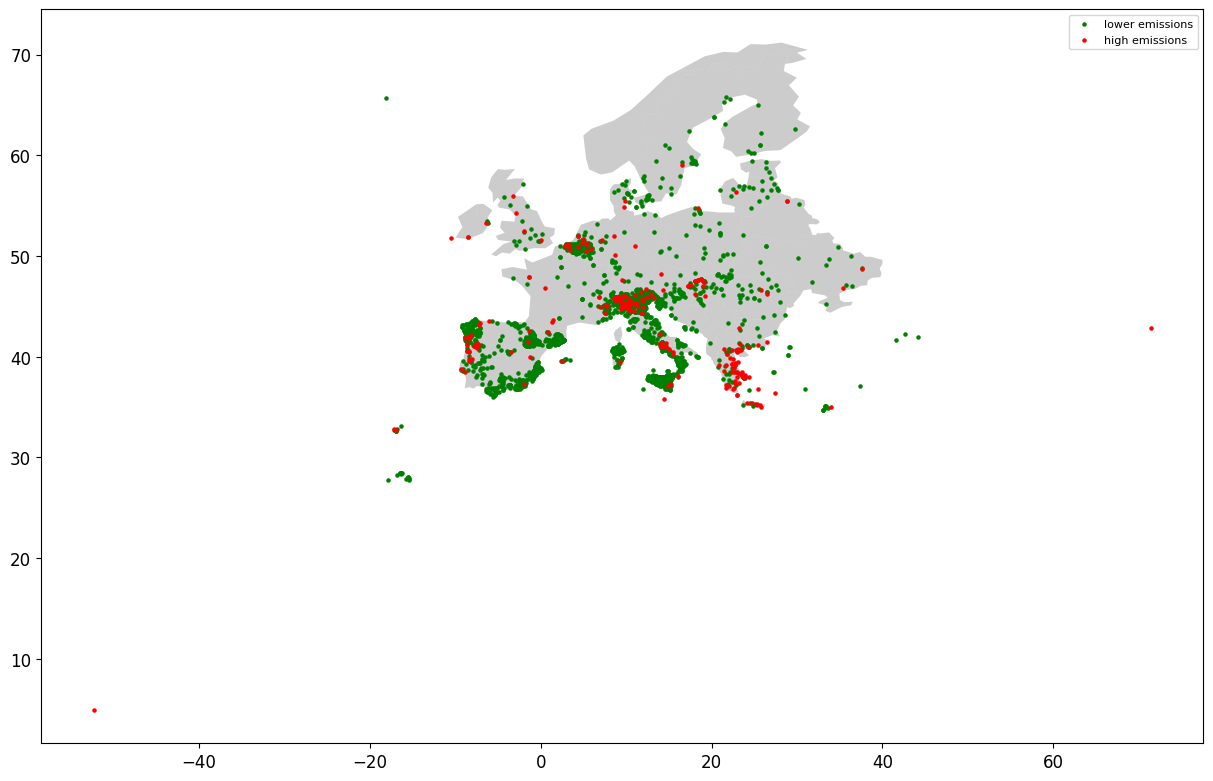

In [ ]:
# plot high-emission cities 
fig, ax = plt.subplots(figsize=(15,15))
europe.plot(ax=ax, alpha=0.4, color='grey')
geo_df1[geo_df1['high_emissions'] == 0].plot(ax=ax, 
                                       markersize=5, 
                                       color='green', 
                                       marker='o', 
                                       label='lower emissions')
geo_df1[geo_df1['high_emissions'] == 1].plot(ax=ax, 
                                       markersize=5, 
                                       color='red', 
                                       marker='o', 
                                       label='high emissions')
plt.legend(prop={'size':8})

### 5.2.2 Plot predicted emissions of non-reporting cities on map

In [ ]:
# Create dataframe with Decision Tree predicted cities 
dt_map = cities_df_pred[cities_df_pred['Pred_DT'] == 1] 

# Create dataframe with XGB predicted cities 
xgb_map = cities_df_pred[cities_df_pred['Pred_XGB'] == 1] 

In [ ]:
# create points to describes the longitude and latitude of each city according to Decision Tree model
geometry_dt = [Point(xy) for xy in zip(dt_map['Long'], dt_map['Lat'])]
crs = {'init':'epsg:4326'}
geo_df_dt = gpd.GeoDataFrame(dt_map, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry_dt) #specify the geometry list we created
geo_df_dt.head()

,name,Pred_DT,Pred_XGB,Lat,Long,geometry
533,Kozani,1,0,40.30,21.79,POINT (21.79000 40.30000)
534,Ptolemaida Eordea,1,0,40.51,21.68,POINT (21.68000 40.51000)
773,Almería,1,0,36.84,-2.47,POINT (-2.47000 36.84000)
790,Chirivel,1,1,37.60,-2.26,POINT (-2.26000 37.60000)
803,María,1,1,37.71,-2.17,POINT (-2.17000 37.71000)


In [ ]:
# create points to describes the longitude and latitude of each city according to xgb model
geometry_xgb = [Point(xy) for xy in zip(xgb_map['Long'], xgb_map['Lat'])]
crs = {'init':'epsg:4326'}
geo_df_xgb = gpd.GeoDataFrame(xgb_map, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry_xgb) #specify the geometry list we created
geo_df_xgb.head()

,name,Pred_DT,Pred_XGB,Lat,Long,geometry
341,Chepelare,0,1,41.725830,24.684440,POINT (24.68444 41.72583)
347,Krivodol,0,1,43.397957,23.475118,POINT (23.47512 43.39796)
514,Paggaio,0,1,40.920000,24.250000,POINT (24.25000 40.92000)
517,Volvis,0,1,40.658300,23.403300,POINT (23.40330 40.65830)
518,Thermaikos,0,1,40.500000,22.917000,POINT (22.91700 40.50000)


In [ ]:
# set the figure size and font size for maps
plt.rcParams['figure.figsize']=(12,10)
plt.rcParams['font.size']=12

Text(0.5, 1.0, 'Predicted high emissions cities (non-reporting cities)')

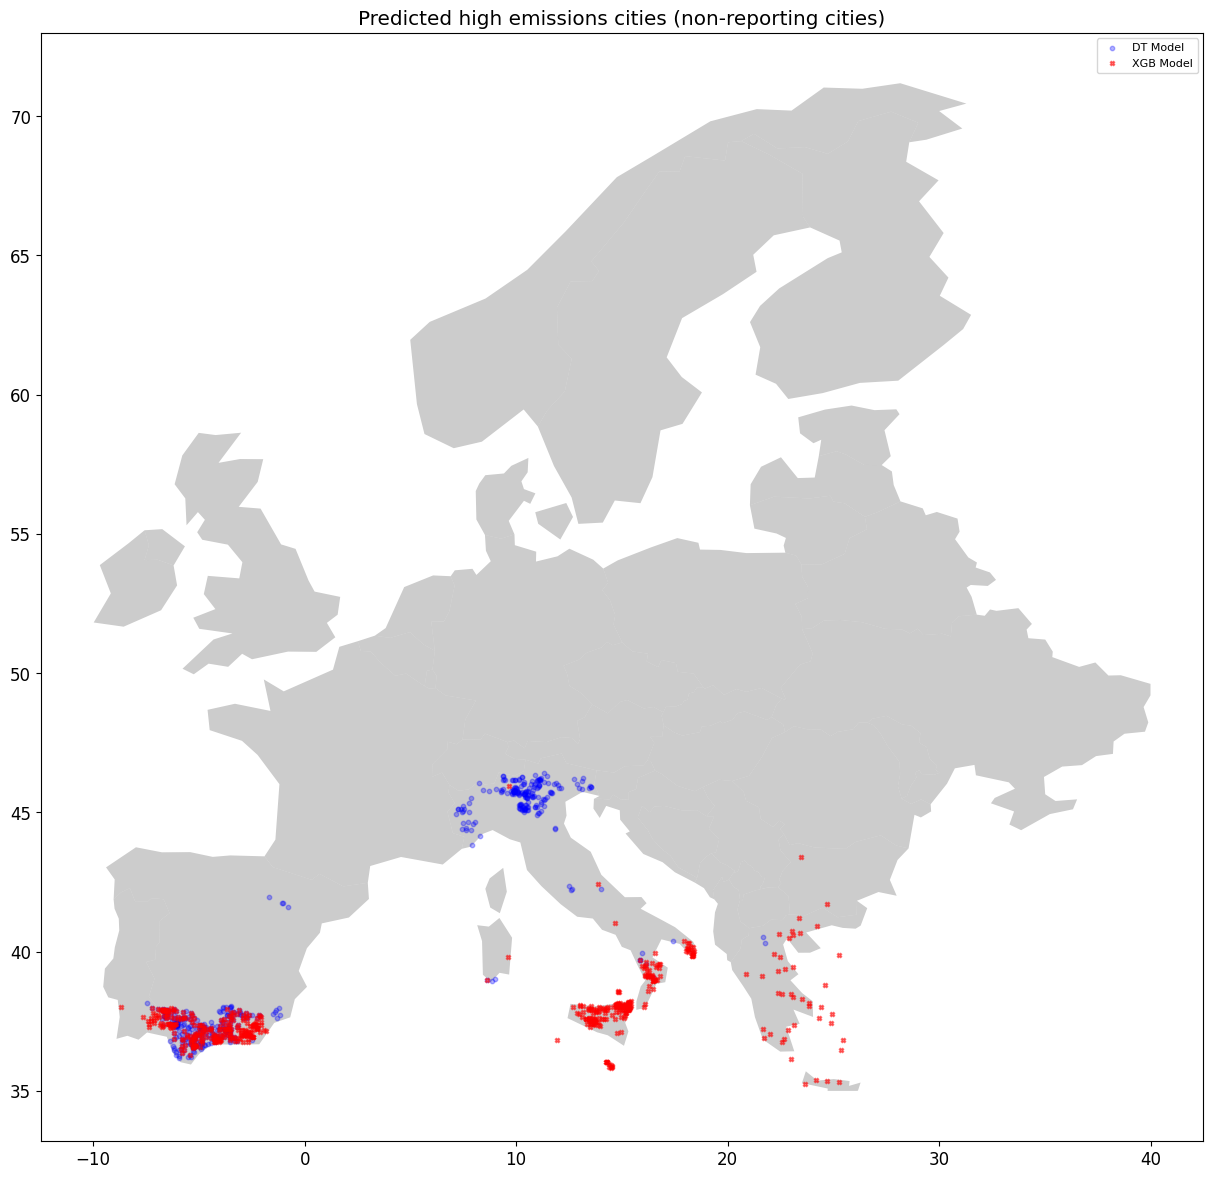

In [ ]:
# plot high-emission cities 
fig, ax = plt.subplots(figsize=(15,15))
europe.plot(ax=ax, alpha=0.4, color='grey')

geo_df_dt['geometry'].plot(ax=ax, 
                                       markersize=10, 
                                       color='blue', 
                                       marker='o',
                                       alpha = 0.3,  
                                       label='DT Model')
geo_df_xgb['geometry'].plot(ax=ax, 
                                       markersize=10, 
                                       color='red', 
                                       marker='X',
                                       alpha = 0.5,  
                                       label='XGB Model')



plt.legend(prop={'size':8})
plt.title('Predicted high emissions cities (non-reporting cities)')